In [1]:
from osgeo import gdal,ogr
import numpy as np
import matplotlib.pyplot as plt

# Enable GDAL/OGR exceptions
gdal.UseExceptions()

In [2]:
##Open netCDF file using GDAL##

fileName = 'S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc' 
ds = gdal.Open(fileName)

In [3]:
##Retrieve an overview of the file content##

dataInfo = gdal.Info(ds)
print(dataInfo)

Driver: netCDF/Network Common Data Format
Files: S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc
Size is 512, 512
Metadata:
  NC_GLOBAL#author=David Bekaert
  NC_GLOBAL#Conventions=CF-1.6
  NC_GLOBAL#institution=Jet Propulsion Laboratory
  NC_GLOBAL#ogr_geometry_field=productBoundingBox
  NC_GLOBAL#ogr_layer_name=productBoundingBox
  NC_GLOBAL#ogr_layer_type=POLYGON
  NC_GLOBAL#product_type=UNW GEO IFG
  NC_GLOBAL#references=https://aria.jpl.nasa.gov/
  NC_GLOBAL#source=Contains modified Copernicus Sentinel data processed by ESA and ARIA NASA/JPL
  NC_GLOBAL#title=ARIA standard product UNW GEO IFG
  NC_GLOBAL#version=1b
Subdatasets:
  SUBDATASET_1_NAME=NETCDF:"S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc":productBoundingBox
  SUBDATASET_1_DESC=[1x464] productBoundingBox (8-bit character)
  SUBDATASET_2_NAME=NETCDF:"S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc":/science/grids/data/unwrappedPh

In [4]:
##Open and retrieve information of the unwrapped phase##

unwPhase = gdal.Open("NETCDF:S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc:/science/grids/data/unwrappedPhase")
unwPhaseInfo = gdal.Info(unwPhase)
print(unwPhaseInfo)

Driver: netCDF/Network Common Data Format
Files: S1-GUNW-A-R-077-tops-20190222_20190210-231605-42666N_40796N-PP-d75b-v2_0_1.nc
Size is 4232, 2246
Coordinate System is:
GEOGCRS["unknown",
    DATUM["unnamed",
        ELLIPSOID["Spheroid",6378137,298.257223563,
            LENGTHUNIT["metre",1,
                ID["EPSG",9001]]]],
    PRIMEM["Greenwich",0,
        ANGLEUNIT["degree",0.0174532925199433,
            ID["EPSG",9122]]],
    CS[ellipsoidal,2],
        AXIS["latitude",north,
            ORDER[1],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]],
        AXIS["longitude",east,
            ORDER[2],
            ANGLEUNIT["degree",0.0174532925199433,
                ID["EPSG",9122]]]]
Data axis to CRS axis mapping: 2,1
Origin = (-81.866250000000022,42.667083333333366)
Pixel Size = (0.000833333333333,-0.000833333333333)
Metadata:
  /science/grids/data/crs#crs_wkt=GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["

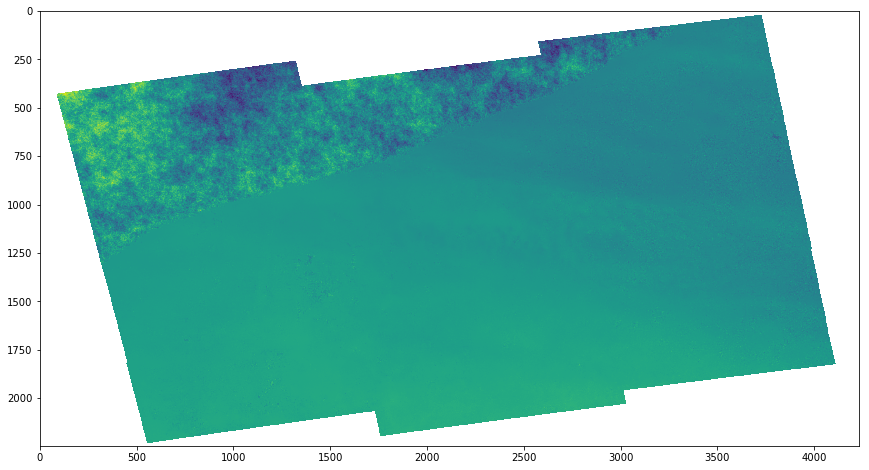

In [8]:
##Read unwrapped phase as python array, mask 0 value pixels and plot##

unwData = unwPhase.GetRasterBand(1).ReadAsArray()
unwDataMasked = np.ma.masked_array(unwData, mask=unwData==0, fill_value=999999)
plt.rcParams['figure.figsize'] = [20, 8]
fig = plt.imshow(unwDataMasked,cmap='viridis')

In [10]:
##Generate a kmz from the unwrapped phase##

translateOptions = gdal.TranslateOptions(gdal.ParseCommandLine('-of KMLSUPEROVERLAY -scale -co format=png'))
kmzFile = gdal.Translate("unwrappedPhase.kmz", unwPhase, options=translateOptions)

In [12]:
##Crop and generate a kmz from the unwrapped phase##

translateOptions = gdal.TranslateOptions(gdal.ParseCommandLine('-of KMLSUPEROVERLAY -scale -co format=png -projwin -81.00 42.30 -80.00 41.50'))
kmzFileCrop = gdal.Translate("unwrappedPhaseCrop.kmz", unwPhase, options=translateOptions)